# Prepare ENV/Load libraries

## Mount Google Drive

In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/"

# change directory to the project path

project_path = os.path.join(google_drive_path, "Colab Notebooks/SER ME/")
os.chdir(project_path)
os.listdir("./")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['Multi-Layers Transformer.ipynb',
 'utils',
 'fonts',
 'meta_data',
 'dataset',
 '.git',
 '.env',
 'config.yml',
 'libs',
 'README.md',
 'models',
 'Notebook Template.ipynb',
 '.gitignore',
 'Preprocess Json to CSV.ipynb',
 'logs',
 'HyperParams Tuning Train Transformer.ipynb',
 'Tensorboard vis.ipynb',
 'HyperParams Tuning Train LSTM.ipynb',
 'Untitled0.ipynb']

In [ ]:
# !rm -rf tmp && git clone https://github.com/chuan-khuna/my-python-utils.git tmp && cp -R tmp/utils ./ && cp -R tmp/fonts ./ && rm -rf tmp

Cloning into 'tmp'...
remote: Enumerating objects: 557, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 557 (delta 112), reused 64 (delta 50), pack-reused 358
Receiving objects: 100% (557/557), 6.05 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (193/193), done.
Checking out files: 100% (119/119), done.


In [ ]:
!python3 --version

Python 3.8.16


In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf2onnx 1.13.0 requires flatbuffers<3.0,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
onnx 1.13.0 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.


In [ ]:
!pip install matplotlib seaborn -Uq
!pip install pythainlp -q
!pip install keras-tuner -q
!pip install pyYAML -q
!pip install tensorflow-io[tensorflow] tf2onnx onnxruntime -Uq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.0 which is incompatible.


In [ ]:
%load_ext tensorboard

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patheffects
import seaborn as sns

import json
import yaml
import re
from tqdm.notebook import trange, tqdm

import datetime

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner
from tensorflow.keras.layers import *
from tensorflow import keras

seed_ = 20200218
tf.random.set_seed(seed_)
np.random.seed(seed_)

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from utils.tf_layers.transformer_arch.model import Encoder
from utils.tf_layers.transformer_arch.transformer import TransformerEncoderBlock as TransformerEncoder
from utils.tf_layers.transformer_arch.embedding import FixedPositionalEncoding

## Ensure that matplotlib can use subplot mosaic

In [ ]:
def check_version(version_str, major, minor):
    print(version_str)
    version = [int(i) for i in version_str.split('.')]
    assert version[0] >= major and version[1] >= minor

check_version(matplotlib.__version__, 3, 6)
check_version(sns.__version__, 0, 12)

del check_version

matplotlib.__version__, sns.__version__, tf.__version__

3.6.2
0.12.1


('3.6.2', '0.12.1', '2.9.0')

In [ ]:
import tf2onnx
import onnx
import onnxruntime as rt

In [ ]:
import librosa
from librosa.display import specshow
import tensorflow_io as tfio
from IPython.display import Audio

In [ ]:
from utils.vis_utils import *
from libs.audio_preprocessing import AudioPreprocessor

font_dir = [f"{google_drive_path}/code_assets/fonts/"]
mpl_import_fonts(font_dir)

In [ ]:
def get_timestamp():
    timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y%m%d-%H%M")
    return timestamp

get_timestamp()

'20221221-0434'

## View hardware spec

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
tf.config.list_physical_devices('GPU')

for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

## Config Tensorflow precision

In [ ]:
# use mixed precision

# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

# Load Dataframe

In [ ]:
df = pd.read_csv("./meta_data/dataset.csv")

In [ ]:
# drop emotion label that tagged as None
df = df[df['majority_emo'] != 'None']
df = df[df['majority_emo'] != 'other']
df = df[df['agreement'] >= 0.6]

# shuffle
df = df.sample(frac=1.0)

In [ ]:
label_col = "majority_emo"

In [ ]:
label_col = "majority_emo"
df = df.join(pd.get_dummies(df[label_col]))

In [ ]:
df

,path,file,assigned_emo,majority_emo,agreement,Angry,Frustrated,Happy,Neutral,Sad
13355,./dataset/studio11-20/studio014/con/s014_con_a...,s014_con_actor027_script1_2_4a.flac,Sad,Sad,1.000000,0,0,0,0,1
18316,./dataset/zoom1-10/zoom005/mic/z005_mic_actor0...,z005_mic_actor046_impro4_18.flac,Frustrated,Frustrated,0.857143,0,1,0,0,0
14723,./dataset/studio11-20/studio016/con/s016_con_a...,s016_con_actor031_script1_1_5b.flac,Frustrated,Frustrated,0.833333,0,1,0,0,0
2862,./dataset/zoom11-20/zoom019/mic/z019_mic_actor...,z019_mic_actor074_script2_1_4a.flac,Sad,Neutral,0.625000,0,0,0,1,0
13443,./dataset/studio11-20/studio014/con/s014_con_a...,s014_con_actor028_impro2_17.flac,Happy,Happy,0.714286,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
32481,./dataset/studio21-30/studio021/con/s021_con_a...,s021_con_actor078_script3_2_1a.flac,Neutral,Neutral,1.000000,0,0,0,1,0
1582,./dataset/zoom11-20/zoom016/mic/z016_mic_actor...,z016_mic_actor067_script1_2_5a.flac,Frustrated,Frustrated,0.800000,0,1,0,0,0
22912,./dataset/studio31-40/studio040/con/s040_con_a...,s040_con_actor119_script1_2_3b.flac,Happy,Happy,0.666667,0,0,1,0,0
33177,./dataset/studio21-30/studio028/con/s028_con_a...,s028_con_actor095_script2_1_1a.flac,Neutral,Neutral,0.800000,0,0,0,1,0


In [ ]:
classes = pd.get_dummies(df[label_col]).columns
num_classes = len(classes)
list(classes)

['Angry', 'Frustrated', 'Happy', 'Neutral', 'Sad']

In [ ]:
class_weight = {}
for i, c in enumerate(list(classes)):
    class_size = (df[label_col] == c).sum()
    class_weight[i] = np.round(1/class_size * len(df)/2.0, 3)

class_weight

{0: 3.454, 1: 1.813, 2: 2.582, 3: 1.819, 4: 4.507}

In [ ]:
# No class_weight

# class_weight = None

In [ ]:
def show_tensor(tensor, take_n=3):
    return list(tensor.take(take_n).as_numpy_iterator())

In [ ]:
def plot_spectrogram(tensor):
    fig = plt.figure(figsize=(9, 3), dpi=100)
    sns.heatmap(tensor.numpy().squeeze())
    plt.show()

# Config Proprocessing process

In [ ]:
img_w, img_h = n_timesteps, n_features = 512, 64

prep = AudioPreprocessor()

prep.img_h = img_h
prep.img_w = img_w
prep.img_ch = 1
prep.nfft = 512
prep.window_length = 512
prep.mel_sr = 44100
prep.n_mels = 128

In [ ]:
setting = prep.__dict__
setting['classes'] = list(classes)
setting['class_weight'] = class_weight
setting

{'nfft': 512,
 'window_length': 512,
 'stride': 256,
 'mel_sr': 44100,
 'n_mels': 128,
 'max_db': 80,
 'img_h': 64,
 'img_w': 512,
 'img_ch': 1,
 'classes': ['Angry', 'Frustrated', 'Happy', 'Neutral', 'Sad'],
 'class_weight': {0: 3.454, 1: 1.813, 2: 2.582, 3: 1.819, 4: 4.507}}

# Load Tensorflow dataset from df

In [ ]:
def load_file_as_spectrogram_map(x, y):
    tensor = prep.from_file(x)
    tensor = prep._normalize(tensor)
    tensor = prep.preprocess(tensor)
    return tensor, y

def preprocess_spectrogram_map(x, y):
    x = tf.transpose(x, perm=[1, 0, 2])
    x = tf.image.resize(x, size=(n_timesteps, n_features))
    return tf.squeeze(x), y

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((df['path'], df[list(classes)]))

ds = ds.map(load_file_as_spectrogram_map)
ds = ds.map(preprocess_spectrogram_map)

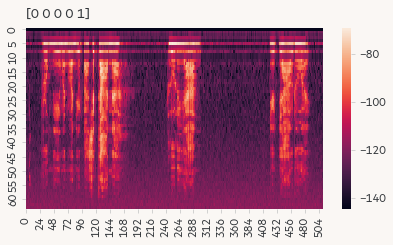

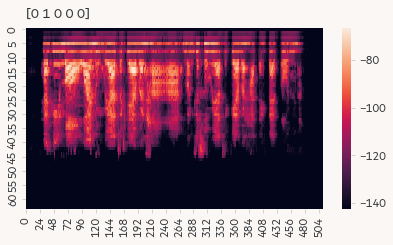

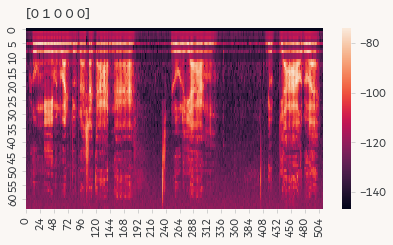

In [ ]:
for x, y in ds.take(3):
    fig = plt.figure(figsize=(6, 3), dpi=80)
    sns.heatmap(x.numpy().T)
    plt.title(str(y.numpy()))
    plt.show()

## Split dataset

In [ ]:
TRAIN_SIZE, VAL_SIZE = 0.7, 0.2

TRAIN_SIZE, VAL_SIZE = int(TRAIN_SIZE*len(df)), int(VAL_SIZE*len(df))
TEST_SIZE = len(df) - (TRAIN_SIZE + VAL_SIZE)
TRAIN_SIZE, VAL_SIZE, TEST_SIZE

(9067, 2590, 1296)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
SHUFFLE_SIZE = 500

# split train-validation
train_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_, reshuffle_each_iteration=False).take(TRAIN_SIZE)
val_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_,
                    reshuffle_each_iteration=False).skip(TRAIN_SIZE).take(VAL_SIZE)
test_ds = ds.shuffle(SHUFFLE_SIZE, seed=seed_,
                     reshuffle_each_iteration=False).skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

# prepare to train
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Model

Hypermodel

Search for best batch size

```py
def fit(self, hp, model, *args, **kwargs):

    AUTOTUNE = tf.data.AUTOTUNE
    batch_size = hp.Choice('batch_size', [64, 32, 24, 16, 8])

    data = args[0]
    train_data = data.batch(batch_size).cache().prefetch(AUTOTUNE)

    if 'validation_data' in kwargs.keys():
        val_data = kwargs['validation_data'].batch(batch_size).cache().prefetch(AUTOTUNE)
        kwargs['validation_data'] = val_data
        hist = model.fit(train_data, **kwargs)
    else:
        hist = model.fit(train_data, **kwargs)

    return hist
```

deprecated LSTM hyperparams
```py
lstm_dropout = hp.Choice(f'lstm_{i}_dropout', [0.1, 0.2, 0.25, 0.3, 0.4, 0.5])
rec_act = hp.Choice(f"lstm_{i}_reccurent_act", ['tanh', 'relu', 'leaky_relu', 'gelu'])
act = hp.Choice(f"lstm_{i}_act", ['tanh', 'sigmoid'])

dropout=lstm_dropout
recurrent_dropout=lstm_dropout,
recurrent_activation=rec_act,
activation=act
```

## Transformer Layer

In [ ]:
# define transformer model
# ...

class SERTransformer(tf.keras.Model):
    def __init__(self, *, 
                 n_timesteps, n_features, filter_size, kernel_size, num_conv_layers, 
                 num_layers, num_heads, dense_dim, output_dim):
        super().__init__()

        self.num_layers = num_layers
        self.num_heads = num_heads

        self.conv = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=(n_timesteps, n_features)),
            keras.layers.Conv1D(filter_size, kernel_size),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(),
        ])

        for i in range(num_conv_layers-1):
            self.conv.add(keras.layers.Conv1D(filter_size, kernel_size))
            self.conv.add(keras.layers.BatchNormalization())
            self.conv.add(keras.layers.MaxPool1D())


        self.embedding_dim = self.conv.output.shape[-1]


        self.pos_encoding = FixedPositionalEncoding(seq_length=2048, embed_dim=self.embedding_dim)
        self.encoders = [
            TransformerEncoder(
                embedding_dim=self.embedding_dim,
                num_heads=self.num_heads,
                dense_dim=dense_dim)
            for _ in range(self.num_layers)
        ]
        self.global_avg = keras.layers.GlobalAveragePooling1D()
        self.dense = keras.layers.Dense(output_dim, activation='softmax')

    def call(self, x):
        x = self.conv(x)
        x = self.pos_encoding(x)
        for i in range(self.num_layers):
            x = self.encoders[i](x)
        x = self.global_avg(x)
        x = self.dense(x)
        return x

In [ ]:
model = SERTransformer(n_timesteps=n_timesteps,
                       n_features=n_features, filter_size=64, 
                       kernel_size=5, num_conv_layers=4,
                       num_layers=4, num_heads=4, dense_dim=256,
                       output_dim=num_classes)

In [41]:
for x, y in (train_ds.take(1)).as_numpy_iterator():
    break

model(x, training=False)

<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[0.5277597 , 0.10045543, 0.12841314, 0.02625619, 0.2171155 ],
       [0.5365944 , 0.10251975, 0.11790773, 0.02509119, 0.21788682],
       [0.5574784 , 0.09598249, 0.1113909 , 0.02449941, 0.21064872],
       [0.5197575 , 0.1072582 , 0.12441819, 0.0288483 , 0.21971782],
       [0.53816193, 0.09306827, 0.13261637, 0.02808882, 0.20806465],
       [0.5182295 , 0.10236683, 0.12708703, 0.02641788, 0.22589877],
       [0.53891695, 0.09430267, 0.13261633, 0.02893539, 0.20522867],
       [0.52777386, 0.09968455, 0.12858307, 0.02814703, 0.2158114 ],
       [0.5328311 , 0.10387327, 0.11860629, 0.02611967, 0.21856976],
       [0.5361755 , 0.09310517, 0.1290313 , 0.02756843, 0.21411963],
       [0.5367679 , 0.10094497, 0.12210809, 0.02432957, 0.21584943],
       [0.5296546 , 0.10716192, 0.11716374, 0.02632048, 0.21969919],
       [0.5474654 , 0.09478516, 0.12049885, 0.02693927, 0.21031132],
       [0.5025099 , 0.11116211, 0.13304192, 0.02731798

In [42]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0,
#                                beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# model.compile(
#     optimizer=opt,
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

In [43]:
def my_model_report(hist,
                    metrics,
                    labels_dict,
                    conf_ticks,
                    fig_title="",
                    save_path="",
                    row_h=2.5,
                    dpi=100):

    # extract metrics in tensorflow's hist obj
    metrics_in_hist = []
    for k in hist.history.keys():
        if not k.startswith('val_'):
            metrics_in_hist.append(k)
    metrics = [metric for metric in metrics if metric in metrics_in_hist]

    # create plot template
    fig_h = (len(metrics) + 1) * row_h
    conf_mosaic = [['conf_train', 'conf_val', 'conf_test']]
    fig_mosaic = [[metric] * 3 for metric in metrics]
    fig, axs = plt.subplot_mosaic(fig_mosaic + conf_mosaic, figsize=(fig_h, fig_h), dpi=dpi)

    plt.suptitle(fig_title)

    # plot epoch history
    epochs = hist.epoch
    for metric in metrics:
        sns.lineplot(x=epochs, y=hist.history[metric], label=metric, ax=axs[metric])

        val_metric = 'val_' + metric
        if val_metric in hist.history.keys():
            sns.lineplot(x=epochs, y=hist.history[val_metric], label=val_metric, ax=axs[metric])
            axs[metric].grid(True, alpha=0.2)

    # plot confusion matrix
    valid_keys = ['train', 'val', 'test']
    for k in list(labels_dict.keys()):
        if k in valid_keys:
            data = labels_dict[k]
            if 'true' in list(data.keys()) and 'pred' in list(data.keys()):
                true_labels = data['true']
                pred_labels = data['pred']
                sns.heatmap(confusion_matrix(true_labels, pred_labels),
                            annot=True,
                            fmt='d',
                            square=True,
                            cbar=False,
                            ax=axs[f'conf_{k}'],
                            xticklabels=conf_ticks,
                            yticklabels=conf_ticks)
                axs[f'conf_{k}'].set_title(f'confusion matrix {k}')

    for k in valid_keys:
        if k not in list(labels_dict.keys()):
            axs[f'conf_{k}'].axis('off')

    axs['conf_train'].set_title('confusion matrix train')
    axs['conf_train'].set_xlabel('pred')
    axs['conf_train'].set_ylabel('actual')

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200)
    plt.show()

In [44]:
def train_model(model, epochs, class_weight, timestamp):

    log_dir = os.path.join("logs/tb_logs", timestamp)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    monitoring_metric = 'val_loss'
    metric_delta = 0.001
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=monitoring_metric,
                                                patience=32,
                                                min_delta=metric_delta)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitoring_metric,
                                                    patience=24,
                                                    min_delta=metric_delta,
                                                    cooldown=16,
                                                    min_lr=1e-8)
    checkpoint_filepath = f'./models/{timestamp}/checkpoint'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                    monitor=monitoring_metric,
                                                    save_best_only=True)

    callbacks = [tensorboard_callback, early_stop, reduce_lr, checkpoint]
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0,
                               beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    if class_weight:
        hist = model.fit(
                        train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks=callbacks,
                        class_weight=class_weight, verbose=2)
    else:
        hist = model.fit(
                        train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks=callbacks, verbose=2)

    model.save(f'./models/{timestamp}/final')

    tf.keras.utils.plot_model(model, show_shapes=True, to_file=f"./models/{timestamp}/model_arch.png")

    with open(f"./models/{timestamp}/preprocess.json", "w") as f:
        f.write(json.dumps(setting, indent=2, ensure_ascii=False))


    train_labels = [label for x, label in (train_ds.take(-1).as_numpy_iterator())]
    val_labels = [label for x, label in (val_ds.take(-1).as_numpy_iterator())]
    test_labels = [label for x, label in (test_ds.take(-1).as_numpy_iterator())]

    train_labels = np.argmax(np.concatenate(train_labels), axis=-1)
    val_labels = np.argmax(np.concatenate(val_labels), axis=-1)
    test_labels = np.argmax(np.concatenate(test_labels), axis=-1)

    pred_train_labels = np.argmax(model.predict(train_ds), axis=-1)
    pred_val_labels = np.argmax(model.predict(val_ds), axis=-1)
    pred_test_labels = np.argmax(model.predict(test_ds), axis=-1)

    metrics = ['loss', 'accuracy']

    labels_dict = {
        'train': {
            'true': train_labels,
            'pred': pred_train_labels
        },
        'val': {
            'true': val_labels,
            'pred': pred_val_labels
        },
        'test': {
            'true': test_labels,
            'pred': pred_test_labels
        }
    }

    ticks = classes

    fig_title = f"{timestamp} | {len(train_labels)}/{len(val_labels)}/{len(test_labels)}"
    save_path = f"./models/{timestamp}.jpg"

    my_model_report(hist,
                    metrics,
                    labels_dict,
                    ticks,
                    fig_title=fig_title,
                    save_path=save_path,
                    row_h=3.5)

    return model

In [45]:
TRAIN_EPOCHS = 256
timestamp = get_timestamp()
timestamp

'20221221-0437'

In [ ]:
model = train_model(model, TRAIN_EPOCHS, class_weight, timestamp)

Epoch 1/256


In [ ]:
%tensorboard --logdir logs/tb_logs